## Introduction

This notebook contains an attempt to solve the [House Prices](https://www.kaggle.com/vikrishnan/house-sales-price-using-regression) regression challenge at Kaggle. If you are going to run this notebook, you should also download the challenge data into a directory `Data/` in the same directory as this notebook.

## Understanding the data 

First things first. We need to understand our data. Lets start by taking a look at the training data.

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from matplotlib import pyplot
from sklearn.preprocessing import Imputer
import warnings

plt.rcParams["figure.figsize"] = (20,3)
warnings.filterwarnings('ignore')
# Setting notebook configs
%matplotlib inline

In [2]:
# Loading data
raw_train = pd.read_csv("Data/train.csv")
raw_test = pd.read_csv("Data/test.csv")
# Describing the data
raw_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
raw_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**Good**. The value we are trying to predict is the `SalePrice`, the last column of the training data. We can see that it is not available in the test data. Now we should plot the data to see if there are any obvious correlations between the attributes, but before that we will remove the ID column and save it elsewhere. And fill missing values. And apply a hashing trick.

In [4]:
# Saving the ids
train_id = raw_train['Id']
test_id = raw_test['Id']
raw_train.drop("Id", axis = 1, inplace = True)
raw_test.drop("Id", axis = 1, inplace = True)

In [5]:
# Hashing trick
val_hash = {}
train = pd.DataFrame()
test = pd.DataFrame()
for dataset in [(raw_train, train), (raw_test, test)]:
    for col in dataset[0].axes[1]: 
        if dataset[0][col].dtype == 'object': # string columns
            if col not in val_hash:
                val_hash[col] = {}
            cid = 0
            for i,val in enumerate(dataset[0][col]):
                if val not in val_hash[col]:
                    val_hash[col][val] = cid
                    cid += 1
            dataset[1][col] = [val_hash[col][x] for x in dataset[0][col]]
        else:
            dataset[1][col] = dataset[0][col]        

In [6]:
# Replacing null values with the mean for the column
train = train.fillna(train.mean())
test = test.fillna(test.mean())

(1460, 80)

Starting with an histogram of the SalePrice variable:

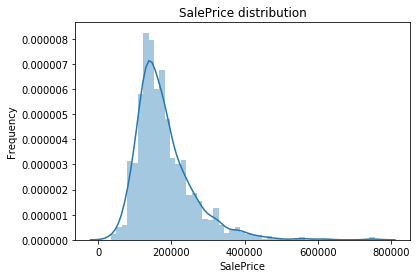

<Figure size 432x288 with 0 Axes>

In [8]:
sns.distplot(train['SalePrice']);
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
plt.show()

Now a correlation matrix with all the variables:

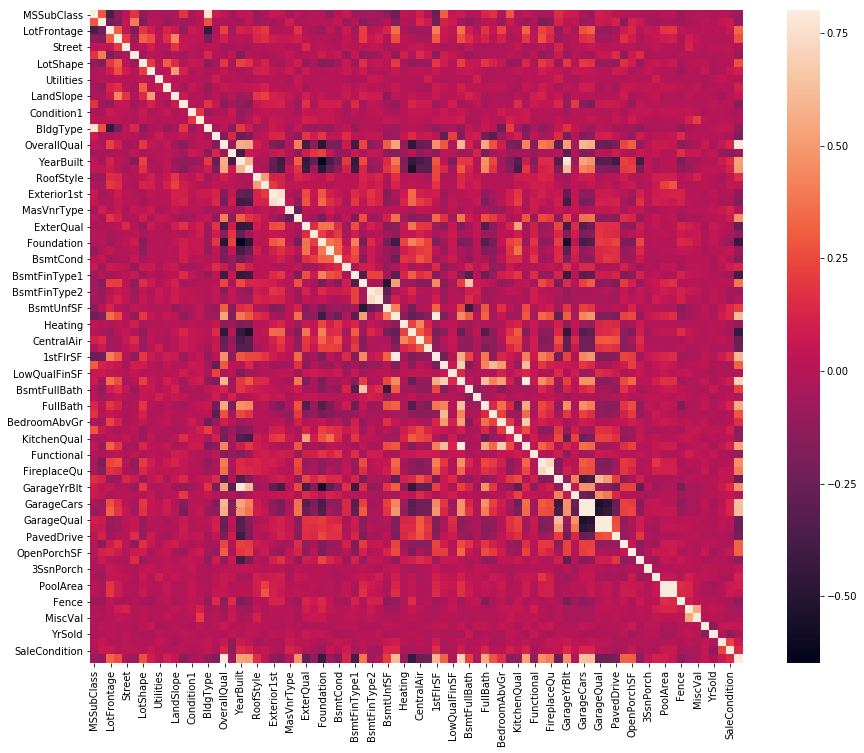

In [9]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=.8, square=True)

Looking specifically at the SalePrice variable, we can see some very interesting features. The variable seems to be well correlated with some other variables such as `OverallQual`, `GrLivArea` and a few others. Looking at the `data_description.txt` file, we see that:

```
OverallQual: Rates the overall material and finish of the house
       10	Very Excellent
       [...]
       1	Very Poor
       
[...]

GrLivArea: Above grade (ground) living area square feet
```

This is a great start, but we must still look further into the data. Lets rank the other variables by their correlation with `SalePrice` and remove the least correlated by an arbitrary `0.5` correlation value:

In [10]:
most_corr = pd.DataFrame(corrmat['SalePrice'])
most_corr = most_corr[most_corr.SalePrice > 0.5]
most_corr

,SalePrice
OverallQual,0.790982
YearBuilt,0.522897
YearRemodAdd,0.507101
TotalBsmtSF,0.613581
1stFlrSF,0.605852
GrLivArea,0.708624
FullBath,0.560664
TotRmsAbvGrd,0.533723
GarageCars,0.640409
GarageArea,0.623431


So we have **10** most correlated features - all of them numerical! Lets plot them aggregating the price values in ranges:

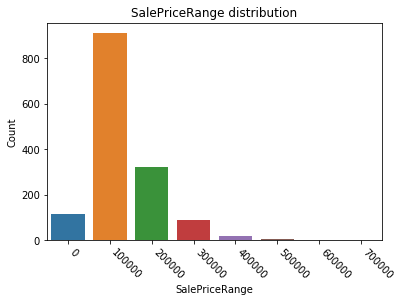

<Figure size 432x288 with 0 Axes>

In [11]:
new_set = pd.DataFrame(train)
bucket_size = 100000
for feature in train.axes[1]:
    if feature not in most_corr.axes[0]:
        new_set.drop(feature, axis = 1, inplace = True)
        
new_set.drop("SalePrice", axis = 1, inplace = True)
SalePriceRange = pd.DataFrame({"SalePriceRange":[str((int(x) // bucket_size) * bucket_size) for x in train["SalePrice"]]})
new_set = pd.concat([new_set, SalePriceRange], axis=1, sort=False)
#range_data = pd.DataFrame({'SalePriceRange': [str((int(x) // bucket_size) * bucket_size) for x in train["SalePrice"]]})
#new_set.join(range_data)
new_set["SalePriceRange"].describe()

sns.countplot(new_set["SalePriceRange"]);
plt.ylabel('Count')
plt.title('SalePriceRange distribution')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(),rotation = (-45), fontsize = 10, va='top', ha='left')
fig = plt.figure()
plt.show()

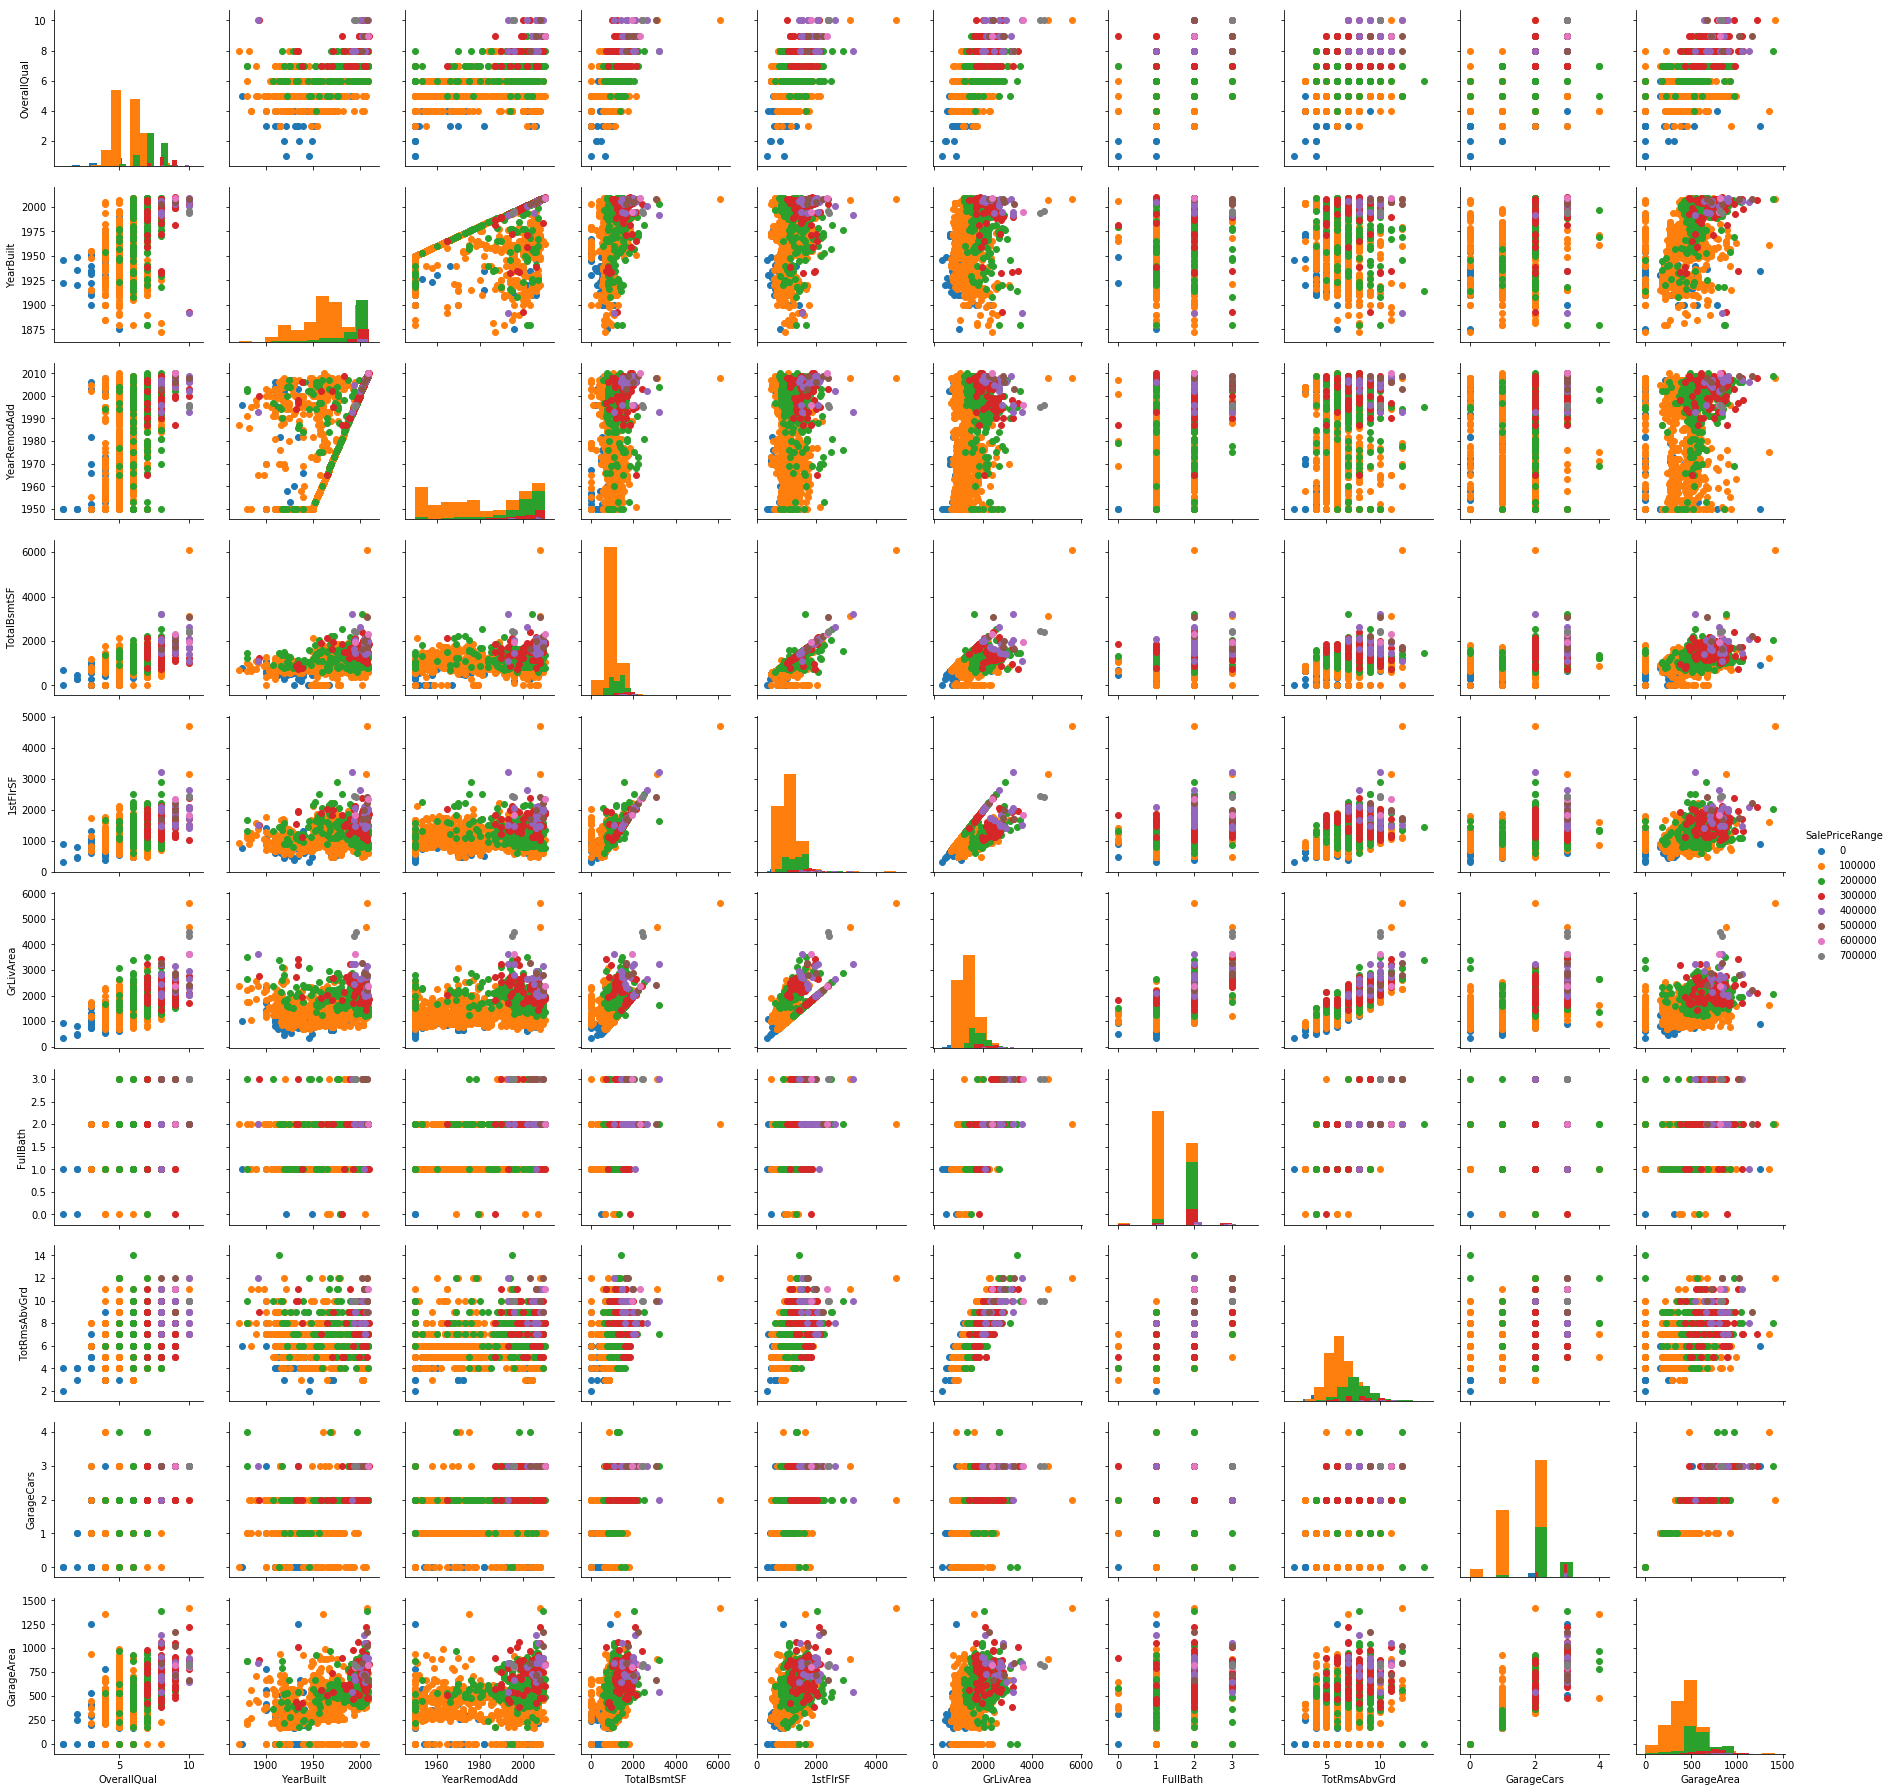

In [12]:
axes_vars = [x for x in new_set.axes[1] if x != "SalePriceRange"]
g = sns.PairGrid(new_set, vars=axes_vars, hue="SalePriceRange")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();


We can play around with the bucket size for this plot for a while, as I did, but even now we can see that there really are some combinations of features with waht seems to be a close to linear distinction of ranges. For example, at the plot [7,4]. Before we start modeling our problem, we must make some considerations about missing data and outliers. For this initial approach I will accept NA values as categoriacal data in all cases - which, for most features, is true, and will ignopre outliers. We may need to revise these decisions later.

For now, lets prepare the training/test data and a bunch of the models we will be comparing.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Lars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

Instantiating multiple regressors:

In [14]:
models = []
models.append(['LR', LinearRegression()])
models.append(['RD', Ridge()])
models.append(['BR', BayesianRidge(compute_score=True)])
models.append(['LASSO', Lasso(alpha=0.015)])
models.append(['LARS', Lars(positive=True)])
models.append(['OMP', OrthogonalMatchingPursuit()])
models.append(['LG', LinearRegression()])
models.append(['EN', ElasticNet(max_iter=30)])
models.append(['KNN', KNeighborsRegressor()])
models.append(['CART', DecisionTreeRegressor()])
models.append(['SVR', SVR()])
models.append(['XGB', xgb.XGBRegressor()])
models.append(['GBR', GradientBoostingRegressor()])
models.append(['LGB', lgb.LGBMRegressor()])

# two groups of feature: those most correlated to our target and all of them
features_all = train.loc[:, train.columns != 'SalePrice'].values
features_mc = new_set.loc[:, new_set.columns != 'SalePriceRange'].values
targets = train.loc[:, train.columns == 'SalePrice'].values.flatten()

Lets also try increasing the dataset in as many dimensions we can in order to increase the number of features with binary values.

In [61]:
new_features = pd.DataFrame()
new_test = pd.DataFrame()
new_cols = {}
threshold = 25
counter = 0
# generate the new columns
for col in train.axes[1]:
    if col == 'SalePrice':
        continue
    if len(np.unique(train[col])) >= threshold:
        new_features[col] = train[col]
    else:
        new_cols[col] = {}
        for val in np.unique(train[col]):
            new_cols[col][val] = []
        for val in train[col]:
            for k,v in new_cols[col].items():
                if k == val:
                    v.append(0)
                else:
                    v.append(1)
        for k,v in new_cols[col].items():
            new_features[col+str(k)] = v
            counter += 1

# generate new test set
for col in test.axes[1]:
    if col in new_cols:
        for k in new_cols[col].keys():
            new_test[col+str(k)] = [(1 if x==k else 0) for x in test[col]]
    else:
        new_test[col] = test[col]
            
print("Added " + str(counter) + " new columns")

Added 269 new columns


In [70]:
metric = "neg_mean_squared_error" 
seed = None
test_size = 0.20
num_folds = 10
results = []
names = []
for i,features in enumerate([features_all, features_mc, new_features.values]):
    for name, model in models:
        kfold = KFold(n_splits=num_folds, random_state=seed)
        res = cross_val_score(model, features, targets, cv=kfold, scoring=metric)
        res = res[abs(res - np.mean(res)) < 3 * np.std(res)]
        results.append(res)
        names.append(name + " " + str(i))
        print("%s %s: %f (%f)" % (name, str(i), np.sqrt(-res.mean()), res.std()))

LR 0: 38352.369385 (1404253626.348016)
RD 0: 36866.777175 (1152176813.274163)
BR 0: 35531.102110 (1022034391.720950)
LASSO 0: 38351.597016 (1404098488.652683)
LARS 0: 41231.139199 (1696274475.944178)
OMP 0: 38407.835646 (835328555.104638)
LG 0: 38352.369385 (1404253626.348016)
EN 0: 36003.106122 (1073285627.088135)
KNN 0: 46510.819297 (855416561.288784)
CART 0: 39501.106408 (861085342.323674)
SVR 0: 81443.384768 (1567149473.726038)
XGB 0: 27464.921833 (294518899.215236)
GBR 0: 26831.054519 (296964565.216350)
LGB 0: 29519.298201 (391518319.716425)
LR 1: 38966.549400 (906998623.180888)
RD 1: 38964.636491 (907224436.979261)
BR 1: 38939.259520 (914235733.640570)
LASSO 1: 38966.548017 (906999397.569994)
LARS 1: 38900.656697 (879545469.734735)
OMP 1: 48695.594606 (640623241.185150)
LG 1: 38966.549400 (906998623.180888)
EN 1: 39498.705692 (1007915219.688071)
KNN 1: 42241.925085 (748785573.354603)
CART 1: 40594.063966 (450255160.245326)
SVR 1: 81443.355897 (1567148890.967785)
XGB 1: 29025.2581

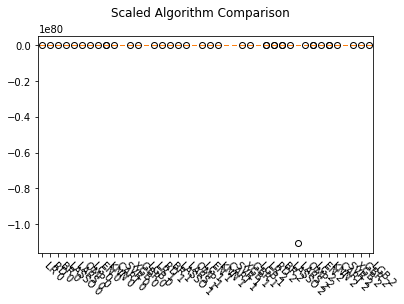

In [71]:
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names,rotation = (-45), fontsize = 10, va='top', ha='left')
pyplot.show()

Lets try againg scaling the data.

In [72]:
pipeline = []
for model in models:
    pipeline.append([model[0], Pipeline([('Scaler', StandardScaler()),(model[0], model[1])])])

In [73]:
results = []
names = []
for i,features in enumerate([features_all, new_features.values]):
    for name, model in pipeline:
        kfold = KFold(n_splits=num_folds, random_state=seed)
        res = cross_val_score(model, features, targets, cv=kfold, scoring=metric)
        res = res[abs(res - np.mean(res)) < 2 * np.std(res)]
        results.append(res)
        names.append(name + " " + str(i))
        print("%s %s: %f (%f)" % (name, str(i), np.sqrt(-res.mean()), res.std()))

LR 0: 39354.191498 (1459519548.634823)
RD 0: 31943.531319 (424930763.429740)
BR 0: 31426.199850 (415472498.544121)
LASSO 0: 31978.338238 (425935677.101571)
LARS 0: 34126.822556 (575230045.012155)
OMP 0: 34931.807276 (354129500.829992)
LG 0: 39354.191498 (1459519548.634823)
EN 0: 31368.686493 (411463794.105994)
KNN 0: 36642.047741 (416530700.353919)
CART 0: 36328.806569 (295832837.409220)
SVR 0: 81411.387692 (1567195021.958897)
XGB 0: 25934.093280 (173362519.310129)
GBR 0: 25328.048643 (158097724.381216)
LGB 0: 27632.759182 (326568527.351541)
LR 1: 199450657347920928.000000 (45922339146729832159263226266124288.000000)
RD 1: 31007.928753 (597377602.471162)
BR 1: 29822.481158 (512744774.159760)
LASSO 1: 30790.577154 (614368724.415701)
LARS 1: 1116306935440247933250830336.000000 (3524619487494455949609743733377077220488059227406860288.000000)
OMP 1: 31055.808162 (608754126.385718)
LG 1: 199450657347920928.000000 (45922339146729832159263226266124288.000000)
EN 1: 28612.854136 (402485842.684

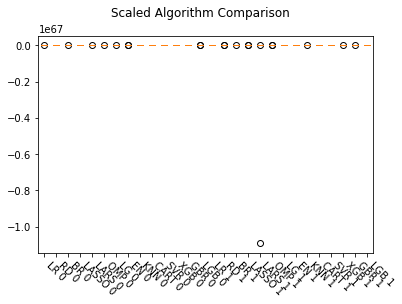

In [50]:
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names,rotation = (-45), fontsize = 10, va='top', ha='left')
pyplot.show()

Consistently our best option is using Gradient Boosting regressors without the standardization process and with all the original hashed features. Lets now try playing around with the parameters of each regressor.

In [55]:
gradient_models = []
gradient_models.append(['XGB', xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.0, 
                                   learning_rate=0.05, max_depth=6, 
                                   min_child_weight=1.5, n_estimators=7200,
                                   reg_alpha=0.9, reg_lambda=0.6,
                                   subsample=0.2, silent=1)])
gradient_models.append(['GBR', GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)])
gradient_models.append(['LGB', lgb.LGBMRegressor(objective='regression',num_leaves=5,
                                   learning_rate=0.05, n_estimators=720,
                                   max_bin = 55, bagging_fraction = 0.8,
                                   bagging_freq = 5, feature_fraction = 0.2319,
                                   feature_fraction_seed=9, bagging_seed=9,
                                   min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)])

results = []
names = []
scaler = StandardScaler().fit(features_all)
rescaled_features = scaler.transform(features_all)
scaler = StandardScaler().fit(new_features.values)
rescaled_new_features = scaler.transform(new_features.values)

for i,rescaled in enumerate([features_all, new_features.values, rescaled_features, rescaled_new_features]):
    for name, model in gradient_models:
        kfold = KFold(n_splits=num_folds, random_state=seed)
        res = cross_val_score(model, rescaled, targets, cv=kfold, scoring=metric)
        res = res[abs(res - np.mean(res)) < 3 * np.std(res)]
        results.append(res)
        names.append(name + " " + str(i))
        print("%s %s: %f (%f)" % (name, str(i), np.sqrt(-res.mean()), res.std()))

KeyboardInterrupt: 

We are going to use the average prediction of the selected regressors to calculate our final results

In [84]:
scaler = StandardScaler().fit(new_features.merge(new_test))
rescaled_features = scaler.transform(new_features.values)
rescatled_test = scaler.transform(new_test.values)

x = rescaled_features # choose one
y = targets
predictions = []
final = []
for name, model in gradient_models:
    regressor = model.fit(x,y)
    predictions.append(regressor.predict(rescatled_test))
    
final = [sum([x[i] for x in predictions])/len(predictions) for i in range(len(test))]

ValueError: Found array with 0 sample(s) (shape=(0, 297)) while a minimum of 1 is required by StandardScaler.

And finally generating the submission

In [77]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = final
sub.to_csv('Data/submission.csv',index=False)

In [92]:
new_test.join(new_features)shape

SyntaxError: invalid syntax (<ipython-input-92-e193f06eba58>, line 1)